In [2]:
from utils import *
from clean.leases import *
from clean.merge_hmlr import *
from clean.rsi import *
import matplotlib.pyplot as plt

In [3]:
tqdm.pandas()

In [4]:
data_folder = '/Users/vbp/Princeton Dropbox/Veronica Backer Peral/Research/natural-rate/ystar-dynamics/data/update_21_08_24'
original_data_folder = '/Users/vbp/Princeton Dropbox/Veronica Backer Peral/Research/natural-rate/ystar-dynamics/data/original'
prev_data_folder = original_data_folder

In [28]:
df = pd.read_pickle(os.path.join(original_data_folder,'clean','leasehold_flats.p'))
df.drop(df[~df.extension].index, inplace=True)
rsi =  pd.read_pickle(os.path.join(original_data_folder,'clean','rsi.p'))[['property_id', 'year', 'quarter', 'd_rsi', 'num_controls', 'radius']]
df = df.merge(rsi, on=['property_id','year','quarter'], indicator=True, how='outer')

df['did_rsi'] = df['d_log_price'] - df['d_rsi']
df['T'] = df.whb_duration
df['k'] = df.extension_amount

df = df[df.year>=2000]
df = df[df['T']>20]
df = df[years_between_dates(df.date_extended - df.L_date_trans.dt.to_period('D')) > 1/12]
df = df[df.years_held>2]

In [57]:
# Get updates
new = pd.read_pickle(os.path.join(data_folder,'clean','leasehold_flats.p'))
new.drop(new[~new.extension].index, inplace=True)
new_rsi =  pd.read_pickle(os.path.join(data_folder,'clean','rsi.p'))[['property_id', 'year', 'quarter', 'd_rsi', 'num_controls', 'radius']]
new = new.merge(new_rsi, on=['property_id','year','quarter'], how='inner')

new['did_rsi'] = new['d_log_price'] - new['d_rsi']
new['T'] = new.whb_duration
new['k'] = new.extension_amount

new = new[new.year>=2000]
new = new[new['T']>20]
new = new[years_between_dates(new.date_extended - new.L_date_trans.dt.to_period('D')) > 1/12]
new = new[new.years_held>2]

In [76]:
cols = ['property_id','date_trans','L_date_trans','d_log_price','d_rsi','did_rsi','whb_duration','extension_amount', 'years_held','year','quarter','month','L_year','L_quarter','L_month']

In [77]:
merged = df.merge(new[cols],  on=['property_id','date_trans'], how='outer', indicator='_new_merge', suffixes=('','_new'))

In [84]:
df[df.year<2000]

,year,years_elapsed,quarter,purchased_lease,postcode,date_registered,extension_amount,date_expired,type,extension,...,whb_duration5yr,whb_duration10yr,whb_duration20yr,whb_durationp1000,num_trans,d_rsi,num_controls,radius,_merge,did_rsi
43,1999,0.306849,2,False,NW3 3EL,1999-04-16,87.264926,NaT,F,True,...,37.42822,37.428224,37.428224,0.037428,5,NaN,NaN,NaN,both,NaN
46,1996,34.400000,4,True,NW3 7SS,NaT,899.999121,2019-04-01,F,True,...,64.60088,64.600879,64.600879,0.064601,4,0.326176,206.0,3.0,both,0.121849
620,1999,-0.008219,4,True,BN2 1FB,1999-12-22,56.017436,NaT,F,True,...,68.99078,68.990783,68.990783,0.068991,6,0.507690,109.0,0.5,both,-0.053435
662,1999,1.536986,3,False,SW10 9JX,1998-12-10,911.242037,NaT,F,True,...,86.22098,86.220976,86.220976,0.086221,7,0.459090,305.0,0.5,both,-0.153864
1195,1999,13.810959,2,False,NW6 1DY,1999-05-04,50.999685,NaT,F,True,...,85.18936,85.189356,85.189356,0.085189,3,0.005321,172.0,0.5,both,0.497599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146458,1999,0.805479,4,False,BH12 5BJ,1999-10-22,34.526611,NaT,F,True,...,89.66791,89.667910,89.667910,0.089668,2,0.212453,36.0,1.0,both,-0.288537
146511,1998,0.484932,4,False,SW18 2NT,1998-09-30,920.012780,NaT,F,True,...,78.50229,78.502289,78.502289,0.078502,6,0.318641,358.0,1.0,both,-0.139173
150895,1999,27.863014,4,True,NW8 0PL,NaT,34.998342,2014-03-21,F,True,...,62.13864,62.138644,62.138644,0.062139,4,-0.105074,71.0,1.0,both,0.589052
151922,1997,2.043836,4,False,SW1V 2AA,1996-09-23,50.776376,NaT,F,True,...,72.17979,72.179789,72.179789,0.072180,2,0.470464,133.0,0.5,both,-0.182782


In [79]:
merged['did_rsi_old'] = merged['did_rsi']
for col in [col for col in merged.columns if col.endswith('_new')]:
    merged.loc[~merged[col].isna(), col.replace('_new','')] = merged[col]

In [80]:
merged[merged.date_trans.dt.year>=2024]

,year,years_elapsed,quarter,purchased_lease,postcode,date_registered,extension_amount,date_expired,type,extension,...,extension_amount_new,years_held_new,year_new,quarter_new,month_new,L_year_new,L_quarter_new,L_month_new,_new_merge,did_rsi_old
41,2024.0,NaN,1.0,NaN,NaN,NaT,909.102816,NaT,NaN,NaN,...,909.102816,17.889117,2024.0,1.0,1.0,2006.0,1.0,2.0,right_only,NaN
54,2024.0,NaN,1.0,NaN,NaN,NaT,89.993964,NaT,NaN,NaN,...,89.993964,8.813142,2024.0,1.0,1.0,2015.0,1.0,3.0,right_only,NaN
197,2024.0,NaN,2.0,NaN,NaN,NaT,899.990969,NaT,NaN,NaN,...,899.990969,13.185489,2024.0,2.0,5.0,2011.0,1.0,3.0,right_only,NaN
226,2024.0,NaN,1.0,NaN,NaN,NaT,90.001870,NaT,NaN,NaN,...,90.001870,17.270363,2024.0,1.0,3.0,2006.0,4.0,11.0,right_only,NaN
230,2024.0,NaN,1.0,NaN,NaN,NaT,89.982470,NaT,NaN,NaN,...,89.982470,25.593429,2024.0,1.0,1.0,1998.0,2.0,6.0,right_only,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147053,2024.0,NaN,2.0,NaN,NaN,NaT,937.649548,NaT,NaN,NaN,...,937.649548,23.660507,2024.0,2.0,6.0,2000.0,4.0,10.0,right_only,NaN
147065,2024.0,NaN,1.0,NaN,NaN,NaT,89.997118,NaT,NaN,NaN,...,89.997118,16.208077,2024.0,1.0,2.0,2007.0,4.0,11.0,right_only,NaN
147163,2024.0,NaN,1.0,NaN,NaN,NaT,899.996401,NaT,NaN,NaN,...,899.996401,5.253936,2024.0,1.0,2.0,2018.0,4.0,11.0,right_only,NaN
147194,2024.0,NaN,1.0,NaN,NaN,NaT,899.995259,NaT,NaN,NaN,...,899.995259,6.921287,2024.0,1.0,1.0,2017.0,1.0,2.0,right_only,NaN


In [81]:
merged[['property_id','date_trans','L_date_trans','d_log_price','d_rsi','did_rsi','did_rsi_old','whb_duration','extension_amount', 'years_held','year','quarter','month','L_year','L_quarter','L_month']].to_stata(os.path.join(original_data_folder,'clean','experiments.dta'), write_index=False)

In [42]:
len(df)

142779

In [7]:
df = load_data(data_folder)

Dropped 2468049 impossible controls.


In [9]:
df[df.property_id.isin(['1 AL1 3NL','1 11 AL1 3QG'])][['property_id','date_trans','L_date_trans','duration','duration2023','extension']]

,property_id,date_trans,L_date_trans,duration,duration2023,extension
78948,1 11 AL1 3QG,2018-04-10,2004-12-10,992.084932,96.0,True
166339,1 AL1 3NL,2023-07-17,2010-06-11,90.934247,91.0,False


In [5]:
residuals = pd.read_pickle(os.path.join(original_data_folder,'working','residuals.p'))

In [6]:
residuals

,pid_control,date_trans_control,residuals,years_held,distance,pid_treated,date_trans_treated
95135,1 AL1 3NL,2023-07-17,-1.094499e-02,13.097878,0.487259,1 11 AL1 3QG,2018-04-10
95140,1 AL1 3PL,2006-08-15,7.770048e-02,7.972621,0.322517,1 11 AL1 3QG,2018-04-10
95146,1 AL1 3UG,2001-06-13,-9.592797e-02,2.168378,0.417802,1 11 AL1 3QG,2018-04-10
95147,1 AL1 3UG,2018-10-12,-9.592797e-02,17.330595,0.417802,1 11 AL1 3QG,2018-04-10
125998,1 CRANMORE COURT AL1 3QS,2015-12-03,1.527405e-01,7.342916,0.323206,1 11 AL1 3QG,2018-04-10
...,...,...,...,...,...,...,...
4620488,D 30 YO30 7DD,2004-06-29,2.904697e-02,3.701574,0.000000,G 30 YO30 7DD,2014-07-30
4628516,E 30 YO30 7DD,2010-03-22,0.000000e+00,11.340178,0.000000,G 30 YO30 7DD,2014-07-30
4671209,G 30 YO30 7DD,2005-01-24,-6.661338e-16,2.403833,0.000000,G 30 YO30 7DD,2014-07-30
4720246,H 30 YO30 7DD,2001-04-27,-9.104865e-03,4.303901,0.000000,G 30 YO30 7DD,2014-07-30


In [5]:
cols = ['property_id','date_trans','L_date_trans','date','L_date','duration','L_duration']

In [6]:
price_var='d_log_price'
case_shiller=True
connect_all=False
add_constant=True
func=apply_rsi
duration_margin=5
parallelize=True
groupby='area'

In [7]:
start_date = 1995*4 + 1
end_date = 2024*4 + 1

In [39]:
df = load_data(data_folder)
extensions = df.drop(df[~df.extension].index)
controls = df.drop(df[(df.extension)].index)

Dropped 2468049 impossible controls.


In [40]:
for df in [extensions, controls]:
    df.drop(df[df[price_var].isna()].index, inplace=True) 
    df["lat_rad"] = np.deg2rad(df["latitude"])
    df["lon_rad"] = np.deg2rad(df["longitude"])

# Get dummies 
controls = get_dummies(controls, start_date=start_date, end_date=end_date)

# Group by postcode area
threshold_size = np.minimum(len(extensions)/n_jobs, 500)
extensions_grouped = split_into_chunks({name: group for name, group in extensions.groupby(groupby)}, threshold_size) 
controls_grouped = {name: group for name, group in controls.groupby(groupby)}

In [ ]:
start = time.time()
skipped=0
chunks = []
for key, group in extensions_grouped:
    durations_list = group['duration2023'].unique()
    print(key, durations_list)

    if key not in controls_grouped:
        skipped += 1
        continue

    controls_subgroup = controls_grouped[key]
    control_dict = {}
    for duration2023 in durations_list:
        control_dict[duration2023] = controls_subgroup[abs(controls_subgroup["duration2023"]-duration2023)<=duration_margin].copy()
    chunks.append((group, control_dict, case_shiller, connect_all, add_constant, price_var, func))
print(f'Skipped {skipped}.')
end = time.time()
print(f'>> Time elapsed: {round((end-start)/60,2)} minutes.')

AL [ 96.  69.  48.  55.  60.  56.  64.  57.  65.  68.  38.  63.  90.  58.
  71.  62.  52.  43.  76.  54.  81.  53.  99.  45.  85. 111.  66.  61.
  49.  80.  84.  67.  77.  42.  39.  78.  59.  88.  44.  47.  34.  36.
 108.  86.  79.  46.  51.  91.  41. 107.  83. 104.  40.  87.  73.  50.
  37. 105. 109.]
AL [ 67.  53.  47.  57.  60.  62.  36.  56.  46.  63.  82.  64.  32.  83.
  61.  78.  51.  66.  34.  50.  59.  87.  39.  79.  74.  40.  72.  55.
  90. 111.  65.  68.  49.  38.  45.  48.  76.  54.  37.  52.  88.  92.
  41.  84.  91. 106. 105.  85.  42.  81. 114.  75. 102.  35.  58.  25.
 108.  69.  43. 120.  96. 110. 119.  44.  86.  77.  80.  73. 109.]
B [ 52.  43.  58.  67.  48.  55. 107.  44.  74.  29.  65.  56.  57.  78.
 108. -37.  83.  64.  46.  60.  47.  51.  38.  42.  45.  49.  36.  69.
  53.  59.  39.  62.  40.  85.  71.  66.  50.  61.  76.  54.  35.  34.
  77. 103.  37.  41.  63. 104.  75.  73.  82.  86.  80.  14. 129.  84.
 101. 119.  32.  70.  68.  79.  90.  87.  72.]
B [ 65.  

In [37]:
t = chunks[0][1][60]

In [38]:
t['test']=1

In [49]:
results = pqdm(chunks, process_chunk, n_jobs=n_jobs) 

valid_results = [r for r in results if isinstance(r, (pd.DataFrame, pd.Series))]
invalid_results = [r for r in results if not isinstance(r, (pd.DataFrame, pd.Series))]
if len(invalid_results)>0:
    print(f"Error! {invalid_results}")

output = pd.concat(valid_results)

QUEUEING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/63 [00:00<?, ?it/s]

Error! [NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind' is not defined"), NameError("name 'UnionFind

ValueError: No objects to concatenate

In [9]:
price = pd.read_pickle(os.path.join(original_data_folder, 'working', 'price_data_leaseholds.p'))
lease = pd.read_pickle(os.path.join(original_data_folder, 'working', 'lease_data.p'))

In [10]:
merge_keys = pd.read_pickle(os.path.join(original_data_folder, 'working', 'merge_keys.p'))

In [12]:
price[price.property_id=='1 100 SE18 6TS'][['property_id','date_trans']]

,property_id,date_trans
2822473,1 100 SE18 6TS,1997-08-04
12443968,1 100 SE18 6TS,2006-10-25


In [14]:
lease[lease.merge_key.str.contains('SE18 6TS')][['merge_key','term']].sort_values(by='merge_key')

,merge_key,term
3417825,1 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417831,2 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417828,3 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417824,4 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417830,5 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417823,6 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417827,7 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417826,8 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
3417829,9 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017
2048119,A 100 BROOKHILL ROAD LONDON SE18 6TS,125 years from 25 March 1989


In [21]:
leases_may2023 = rename_columns(pd.read_csv(os.path.join(original_data_folder, 'raw', 'hmlr', 'LEASES_FULL_2023_05.csv')))
leases_may2023['merge_key'] = leases_may2023.progress_apply(lambda row: get_merge_key(row['associated property description']), axis=1)

new_leases = rename_columns(pd.read_csv(os.path.join(original_data_folder, 'raw', 'hmlr', 'LEASES_FULL_2024_02.csv')))
new_leases = get_new_leases(leases_may2023, new_leases)
new_leases['merge_key'] = new_leases.progress_apply(lambda row: get_merge_key(row['associated property description']), axis=1)

100%|███████████████████████████████| 176944/176944 [00:00<00:00, 377854.53it/s]


In [22]:
leases_may2023[leases_may2023.merge_key.fillna('').str.contains('SE18 6TS')][['merge_key','term','id']].sort_values(by='merge_key')

,merge_key,term,id
6325418,1 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325419,2 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325420,3 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325421,4 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325422,5 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325423,6 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325424,7 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325425,8 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6325426,9 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6075646,A 100 BROOKHILL ROAD LONDON SE18 6TS,125 years from 25 March 1989,2.345055e+07


In [23]:
id = list(lease_raw[lease_raw.merge_key.fillna('').str.contains('SE18 6TS')][['merge_key','term','id']].sort_values(by='merge_key')['id'])[0]
leases_may2023[leases_may2023['id']==id][['merge_key','term','id']]

,merge_key,term,id
6090695,C 100 BROOKHILL ROAD LONDON SE18 6TS,125 years from 25 March 1989,23450545.0


In [17]:
lease_raw = rename_columns(lease_raw)
lease_raw['merge_key'] = lease_raw.progress_apply(lambda row: get_merge_key(row['associated property description']), axis=1)

100%|█████████████████████████████| 7496687/7496687 [00:19<00:00, 384549.27it/s]


In [20]:
lease_raw[lease_raw.merge_key.fillna('').str.contains('SE18 6TS')][['merge_key','term','id']].sort_values(by='merge_key')

,merge_key,term,id
6156825,1 100 BROOKHILL ROAD LONDON SE18 6TS,125 years from 25 March 1989,2.345054e+07
6390933,1 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390934,2 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390935,3 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390936,4 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390937,5 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390938,6 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390939,7 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390940,8 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08
6390941,9 WILMOTT HOUSE 101 BROOKHILL ROAD LONDON SE18...,250 years from and including 9 August 2017,5.039805e+08


In [6]:
df = pd.read_pickle(os.path.join(original_data_folder, 'clean', 'leasehold_flats.p'))

In [7]:
df.to_csv('/Users/vbp/Downloads/test.csv', index=False)

In [8]:
len(df)

4787374

In [40]:
vc = df[(~df.purchased_lease)&(df._merge=='left_only')].date_trans.dt.year.value_counts().reset_index()
tc = df.date_trans.dt.year.value_counts().reset_index().rename(columns={'count':'total'})
x = vc.merge(tc, on='date_trans')
x['sh'] = x['count']/x['total']
x.sort_values(by='date_trans', inplace=True)
plt.plot(x.date_trans, x.sh)

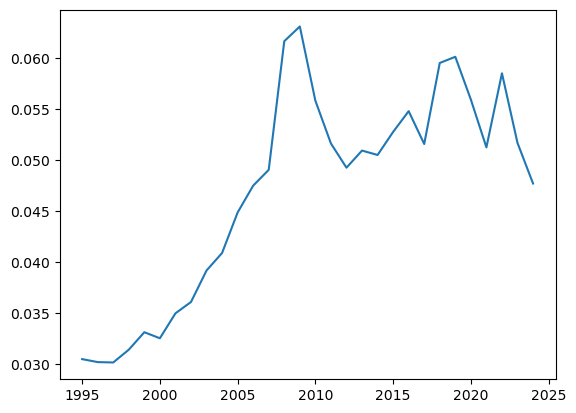